In [1]:
import pandas as pd
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

c:\Users\VSIE43\AppData\Local\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [137]:
data_pth = r'C:\Users\VSIE43\OneDrive - Scania CV\Thesis\SKAB-master\data/'
normal_file = 'anomaly-free/anomaly-free.csv'
test_1 = 'other'
test_2 = 'valve1'
test_3 = 'valve2'

df = pd.read_csv(data_pth + normal_file, sep=';')

def fillin_time_gaps(df):
    df.datetime = pd.to_datetime(df.datetime.values)
    time_diff = np.diff(df.datetime.values)

    new_time = pd.date_range(df.datetime.min(), df.datetime.max(), freq='1s')
    missing_time = pd.DataFrame({'datetime': new_time})
    df_new = missing_time.merge(df, on='datetime', how='left')

    df_new = df_new.interpolate(method='ffill')
    return df_new

normal_data = []
df = pd.read_csv(data_pth + normal_file, sep=';')
normal_data.append(fillin_time_gaps(df).drop(columns=['datetime']))
for folder in [test_2, test_3]:
    files = os.listdir(data_pth + folder)
    for file in files:
        tmp = pd.read_csv(data_pth + folder + '/' + file, sep=';')
        t = tmp[tmp.anomaly == 0]
        t = t.drop(columns=['changepoint'])
        normal_data.append(t)

df = fillin_time_gaps(df)

def min_max_normalize(df, m_m_params=None):
    if m_m_params:
        (min_p, max_p) = m_m_params
    else:
        (min_p, max_p) = df.min(), df.max()

    new_df = (df - min_p) / (max_p - min_p)
    return new_df, (min_p, max_p)

data, m_m_params = min_max_normalize(df.drop(columns=['datetime']))

test_df_1 = pd.read_csv(data_pth + test_1 + '/1.csv', sep=';')
test_df_1_norm, _ = min_max_normalize(test_df_1.drop(columns=['datetime', 'anomaly', 'changepoint']), m_m_params)

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

def create_temporal_features(df):
    features = []
    for t in range(len(df)):
        x_t = torch.tensor(df.iloc[t].values, dtype=torch.float).view(-1, 1)
        features.append(x_t)
    return features

temporal_features_train = create_temporal_features(data)
temporal_features_test = create_temporal_features(test_df_1_norm)

def create_sliding_windows(features, window_size, stride):
    windows = []
    for i in range(0, len(features) - window_size, stride):
        window = features[i:i + window_size]
        windows.append(window)
    return np.array(windows)

window_size = 16
stride = 1

temporal_windows_train = create_sliding_windows(temporal_features_train, window_size, stride)
temporal_windows_test = create_sliding_windows(temporal_features_test, window_size, stride)

class TimeSeriesDataset(Dataset):
    def __init__(self, windows):
        self.windows = windows

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        window = self.windows[idx]
        return window, window

train_dataset = TimeSeriesDataset(temporal_windows_train)
test_dataset = TimeSeriesDataset(temporal_windows_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=False)

In [106]:
class PositionalEncoding(nn.Module):
    def __init__(self, hidden_dim, max_len=5000, dropout=0.3):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        self.encoding = torch.zeros(max_len, hidden_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_dim, 2).float() * (-np.log(10000.0) / hidden_dim))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0).transpose(0, 1)

    def forward(self, x):
        x = x + self.encoding[:x.size(0), :]
        return self.dropout(x)

# Define the AttentionAdjacencyLayer
class AttentionAdjacencyLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, max_len=5000):
        super(AttentionAdjacencyLayer, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

        self.multihead_attn1 = nn.MultiheadAttention(hidden_dim, num_heads)
        self.multihead_attn2 = nn.MultiheadAttention(hidden_dim, num_heads)
        self.multihead_attn3 = nn.MultiheadAttention(hidden_dim, num_heads)
        self.multihead_attn4 = nn.MultiheadAttention(hidden_dim, num_heads)

        self.fc3 = nn.Linear(3 * hidden_dim, 2*hidden_dim)  # To project concatenated output back to hidden_dim
        self.fc4 = nn.Linear(2 * hidden_dim, hidden_dim)  # To project concatenated output back to hidden_dim
        self.fc5 = nn.Linear(hidden_dim, input_dim)

        self.positional_encoding = PositionalEncoding(hidden_dim, max_len)
        self.leakyrelu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        N, W, F = x.shape  # (batch_size, window_size, num_features)
        
        # Apply the first linear layer to the input
        x = self.leakyrelu(self.fc1(x))  # (N, W, hidden_dim)
        
        # Apply the second linear layer
        x = self.leakyrelu(self.fc2(x))  # (N, W, hidden_dim)
        
        # Reshape for multihead attention
        x = x.permute(1, 0, 2)  # (W, N, hidden_dim)

        # Apply positional encoding
        x = self.positional_encoding(x)

        # Apply first multihead attention
        attn_output1, attn_weights1 = self.multihead_attn1(x, x, x)  # (W, N, hidden_dim)

        # Apply second multihead attention
        attn_output2, attn_weights2 = self.multihead_attn2(x, x, x)  # (W, N, hidden_dim)
        
        # Apply third multihead attention
        attn_output3, attn_weights3 = self.multihead_attn3(x, x, x)  # (W, N, hidden_dim)

        # Apply fourth multihead attention
        # attn_output4, attn_weights4 = self.multihead_attn4(x, x, x)  # (W, N, hidden_dim)


        # Concatenate the outputs of all three attention layers
        attn_output = torch.cat((attn_output1, attn_output2, attn_output3), dim=-1)  # (W, N, 3 * hidden_dim)

        # Reshape back
        attn_output = attn_output.permute(1, 0, 2)  # (N, W, 3 * hidden_dim)

        # Apply the third linear layer to project back to hidden_dim
        x = self.leakyrelu(self.fc3(attn_output))  # (N, W, hidden_dim)

        # Apply the fourth linear layer to project back to hidden_dim
        x = self.leakyrelu(self.fc4(x))  # (N, W, hidden_dim)


        # Apply the fourth linear layer
        x = self.fc5(x)  # (N, W, F)

        # Compute the adjacency matrix
        adj_matrix = torch.bmm(x.permute(0, 2, 1), x)  # (N, F, W) * (N, W, F) -> (N, F, F)

        # Apply sigmoid to ensure values are between 0 and 1
        adj_matrix = self.sigmoid(adj_matrix)
        
        return adj_matrix

# Define the GCNLayer
class GCNLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNLayer, self).__init__()
        self.conv = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index, edge_weight=None):
        return self.conv(x, edge_index, edge_weight)

# Define the GNNAnomalyDetection model
class GNNAnomalyDetection(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads, dropout = 0.5):
        super(GNNAnomalyDetection, self).__init__()
        self.adj_layer = AttentionAdjacencyLayer(input_dim, hidden_dim, num_heads)
        self.gcn1 = GCNLayer(input_dim, hidden_dim)
        self.gcn2 = GCNLayer(hidden_dim, hidden_dim)
        self.gcn3 = GCNLayer(hidden_dim, output_dim)
        self.fc = nn.Linear(output_dim, input_dim)
        
        # Define activations
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=dropout)
    def forward(self, x):
        N, W, F = x.shape
        
        adj_matrix = self.adj_layer(x)
        edge_index, edge_weight = self.adj_to_edge_index(adj_matrix)

        gcn_outputs = []
        for t in range(W):
            gcn_output = self.gcn1(x[:, t, :].view(-1, F), edge_index)
            gcn_output = self.relu(gcn_output)
            gcn_output = self.gcn2(gcn_output, edge_index)
            gcn_output = self.relu(gcn_output)
            gcn_output = self.gcn3(gcn_output, edge_index)
            gcn_output = self.relu(gcn_output)
            gcn_output = gcn_output.view(N, F, -1)
            gcn_outputs.append(gcn_output)

        gcn_outputs = torch.stack(gcn_outputs, dim=1)  # Shape: [N, W, F, output_dim]
        gcn_outputs = gcn_outputs.view(N, W, -1)  # Shape: [N, W, F * output_dim]

        x = self.fc(gcn_outputs)
        x = self.sigmoid(x)
        return x, adj_matrix

    def adj_to_edge_index(self, adj_matrix):
        N, F, _ = adj_matrix.shape
        edge_index_list = []
        edge_weight_list = []
        for n in range(N):
            edge_index = torch.nonzero(adj_matrix[n], as_tuple=False).t().contiguous()
            edge_weight = adj_matrix[n][edge_index[0], edge_index[1]]
            edge_index_list.append(edge_index)
            edge_weight_list.append(edge_weight)
        edge_index = torch.cat(edge_index_list, dim=1)
        edge_weight = torch.cat(edge_weight_list)
        return edge_index, edge_weight

In [107]:
input_dim = temporal_windows_train.shape[-2]
hidden_dim = 32
output_dim = temporal_windows_train.shape[-2]
learning_rate = 0.00001
num_epochs = 50
sparsity_weight = 0.5

# Model, Loss, and Optimizer
model = GNNAnomalyDetection(input_dim, hidden_dim, output_dim, num_heads=8)
criterion = nn.SmoothL1Loss(beta=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [108]:
print(model)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

GNNAnomalyDetection(
  (adj_layer): AttentionAdjacencyLayer(
    (fc1): Linear(in_features=8, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=32, bias=True)
    (multihead_attn1): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
    )
    (multihead_attn2): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
    )
    (multihead_attn3): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
    )
    (multihead_attn4): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
    )
    (fc3): Linear(in_features=96, out_features=64, bias=True)
    (fc4): Linear(in_features=64, out_features=32, bias=True)
    (fc5): Linear(in_features=32, out_features=8, bias=True)
    (positional_encoding): PositionalEncoding(
      (dropo

In [109]:
def train_model(train_loader, model, criterion, optimizer, num_epochs=20, sparsity_weight=1e-4):
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
            for windows, _ in train_loader:
                optimizer.zero_grad()
                windows = windows.squeeze(-1).type(torch.float32)
                outputs, adj_matrix = model(windows)
                
                reconstruction_loss = criterion(outputs, windows)
                sparsity_loss = torch.norm(adj_matrix, p=1)
                loss = reconstruction_loss + sparsity_weight * sparsity_loss
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                pbar.update(1)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}')

train_model(train_loader, model=model, criterion=criterion, optimizer=optimizer, num_epochs=num_epochs)

Epoch 1/50: 100%|██████████| 311/311 [00:18<00:00, 16.91it/s]


Epoch [1/50], Loss: 0.1550


Epoch 2/50: 100%|██████████| 311/311 [00:17<00:00, 17.33it/s]


Epoch [2/50], Loss: 0.1533


Epoch 3/50: 100%|██████████| 311/311 [00:18<00:00, 16.62it/s]


Epoch [3/50], Loss: 0.1525


Epoch 4/50: 100%|██████████| 311/311 [00:18<00:00, 17.04it/s]


Epoch [4/50], Loss: 0.1516


Epoch 5/50: 100%|██████████| 311/311 [00:18<00:00, 16.75it/s]


Epoch [5/50], Loss: 0.1455


Epoch 6/50: 100%|██████████| 311/311 [00:18<00:00, 16.65it/s]


Epoch [6/50], Loss: 0.1318


Epoch 7/50: 100%|██████████| 311/311 [00:18<00:00, 17.20it/s]


Epoch [7/50], Loss: 0.1247


Epoch 8/50: 100%|██████████| 311/311 [00:18<00:00, 17.04it/s]


Epoch [8/50], Loss: 0.1214


Epoch 9/50: 100%|██████████| 311/311 [00:18<00:00, 17.04it/s]


Epoch [9/50], Loss: 0.1193


Epoch 10/50: 100%|██████████| 311/311 [00:18<00:00, 16.96it/s]


Epoch [10/50], Loss: 0.1176


Epoch 11/50: 100%|██████████| 311/311 [00:18<00:00, 17.22it/s]


Epoch [11/50], Loss: 0.1163


Epoch 12/50: 100%|██████████| 311/311 [00:18<00:00, 17.12it/s]


Epoch [12/50], Loss: 0.1151


Epoch 13/50: 100%|██████████| 311/311 [00:18<00:00, 17.02it/s]


Epoch [13/50], Loss: 0.1140


Epoch 14/50: 100%|██████████| 311/311 [00:18<00:00, 17.04it/s]


Epoch [14/50], Loss: 0.1129


Epoch 15/50: 100%|██████████| 311/311 [00:18<00:00, 17.04it/s]


Epoch [15/50], Loss: 0.1120


Epoch 16/50: 100%|██████████| 311/311 [00:18<00:00, 16.90it/s]


Epoch [16/50], Loss: 0.1110


Epoch 17/50: 100%|██████████| 311/311 [00:18<00:00, 17.06it/s]


Epoch [17/50], Loss: 0.1102


Epoch 18/50: 100%|██████████| 311/311 [00:18<00:00, 17.12it/s]


Epoch [18/50], Loss: 0.1094


Epoch 19/50: 100%|██████████| 311/311 [00:18<00:00, 17.01it/s]


Epoch [19/50], Loss: 0.1086


Epoch 20/50: 100%|██████████| 311/311 [00:18<00:00, 17.05it/s]


Epoch [20/50], Loss: 0.1079


Epoch 21/50: 100%|██████████| 311/311 [00:18<00:00, 16.74it/s]


Epoch [21/50], Loss: 0.1072


Epoch 22/50: 100%|██████████| 311/311 [00:18<00:00, 17.13it/s]


Epoch [22/50], Loss: 0.1066


Epoch 23/50: 100%|██████████| 311/311 [00:18<00:00, 17.27it/s]


Epoch [23/50], Loss: 0.1060


Epoch 24/50: 100%|██████████| 311/311 [00:17<00:00, 17.90it/s]


Epoch [24/50], Loss: 0.1055


Epoch 25/50: 100%|██████████| 311/311 [00:17<00:00, 17.76it/s]


Epoch [25/50], Loss: 0.1050


Epoch 26/50: 100%|██████████| 311/311 [00:17<00:00, 17.64it/s]


Epoch [26/50], Loss: 0.1045


Epoch 27/50: 100%|██████████| 311/311 [00:17<00:00, 17.67it/s]


Epoch [27/50], Loss: 0.1041


Epoch 28/50: 100%|██████████| 311/311 [00:17<00:00, 17.71it/s]


Epoch [28/50], Loss: 0.1036


Epoch 29/50: 100%|██████████| 311/311 [00:17<00:00, 17.89it/s]


Epoch [29/50], Loss: 0.1032


Epoch 30/50: 100%|██████████| 311/311 [00:17<00:00, 17.58it/s]


Epoch [30/50], Loss: 0.1029


Epoch 31/50: 100%|██████████| 311/311 [00:17<00:00, 17.94it/s]


Epoch [31/50], Loss: 0.1025


Epoch 32/50: 100%|██████████| 311/311 [00:17<00:00, 17.68it/s]


Epoch [32/50], Loss: 0.1022


Epoch 33/50: 100%|██████████| 311/311 [00:17<00:00, 17.66it/s]


Epoch [33/50], Loss: 0.1018


Epoch 34/50: 100%|██████████| 311/311 [00:17<00:00, 17.79it/s]


Epoch [34/50], Loss: 0.1015


Epoch 35/50: 100%|██████████| 311/311 [00:17<00:00, 17.91it/s]


Epoch [35/50], Loss: 0.1012


Epoch 36/50: 100%|██████████| 311/311 [00:17<00:00, 17.55it/s]


Epoch [36/50], Loss: 0.1009


Epoch 37/50: 100%|██████████| 311/311 [00:17<00:00, 17.84it/s]


Epoch [37/50], Loss: 0.1006


Epoch 38/50: 100%|██████████| 311/311 [00:17<00:00, 17.77it/s]


Epoch [38/50], Loss: 0.1004


Epoch 39/50: 100%|██████████| 311/311 [00:17<00:00, 17.71it/s]


Epoch [39/50], Loss: 0.1001


Epoch 40/50: 100%|██████████| 311/311 [00:17<00:00, 17.73it/s]


Epoch [40/50], Loss: 0.0999


Epoch 41/50: 100%|██████████| 311/311 [00:17<00:00, 17.72it/s]


Epoch [41/50], Loss: 0.0996


Epoch 42/50: 100%|██████████| 311/311 [00:17<00:00, 17.96it/s]


Epoch [42/50], Loss: 0.0994


Epoch 43/50: 100%|██████████| 311/311 [00:17<00:00, 17.54it/s]


Epoch [43/50], Loss: 0.0992


Epoch 44/50: 100%|██████████| 311/311 [00:17<00:00, 17.88it/s]


Epoch [44/50], Loss: 0.0990


Epoch 45/50: 100%|██████████| 311/311 [00:17<00:00, 17.76it/s]


Epoch [45/50], Loss: 0.0988


Epoch 46/50: 100%|██████████| 311/311 [00:19<00:00, 15.94it/s]


Epoch [46/50], Loss: 0.0986


Epoch 47/50: 100%|██████████| 311/311 [00:22<00:00, 13.74it/s]


Epoch [47/50], Loss: 0.0984


Epoch 48/50: 100%|██████████| 311/311 [00:22<00:00, 13.67it/s]


Epoch [48/50], Loss: 0.0982


Epoch 49/50: 100%|██████████| 311/311 [00:23<00:00, 13.34it/s]


Epoch [49/50], Loss: 0.0980


Epoch 50/50: 100%|██████████| 311/311 [00:22<00:00, 13.68it/s]

Epoch [50/50], Loss: 0.0978


In [138]:
def evaluate_model(test_loader):
    model.eval()
    with torch.no_grad():
        reconstruction_errors = []
        preds = []
        actual = []
        adj_mats = []
        for windows, _ in test_loader:
            windows = windows.squeeze(-1)
            outputs, adj_mat = model(windows) 
            reconstruction_error = np.sum((outputs.cpu().numpy()-windows.cpu().numpy())**2, axis=(1,2))
            
            reconstruction_errors.append(reconstruction_error)  # Convert to scalar
            # print(torch.tensor(reconstruction_errors))
            preds.append(outputs.cpu().numpy())
            actual.append(windows.cpu().numpy())
            adj_mats.append(adj_mat.cpu().numpy())

    return np.concatenate(adj_mats), np.concatenate(preds), np.concatenate(actual), np.concatenate(reconstruction_errors)

adj_mat, preds, actual, reconstruction_errors_test = evaluate_model(test_loader)
adj_mat_train, preds_train, actual_train, reconstruction_errors_train = evaluate_model(train_loader)


12.158581657409666

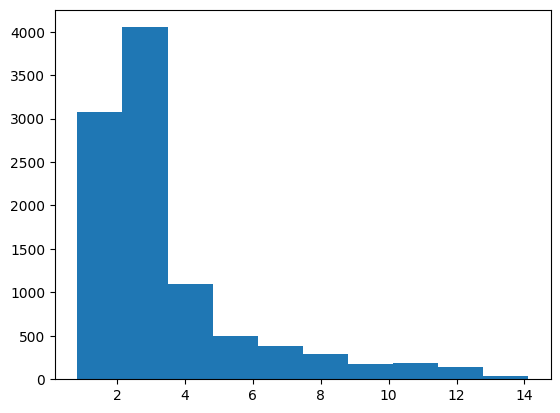

In [111]:
residual_train = np.sum((preds_train-actual_train)**2, axis=(1,2))
plt.hist(residual_train)

threshold = np.percentile(residual_train, 99)
threshold

30.215522483825687

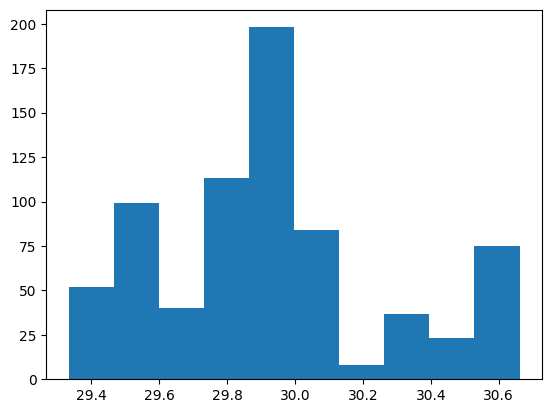

In [155]:
plt.hist(residual_test)
np.percentile(residual_test, 81.15)

In [180]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=25)
thresholds = []

for train_index, val_index in kf.split(residual_test):
    train_losses, val_losses = residual_test[train_index], residual_test[val_index]
    mean_loss = np.mean(train_losses)
    std_loss = np.std(train_losses)
    thresholds.append(mean_loss +  0.7*std_loss)

final_threshold = np.mean(thresholds)
final_threshold

30.166263224244116

In [161]:
final_threshold

30.90231218636036

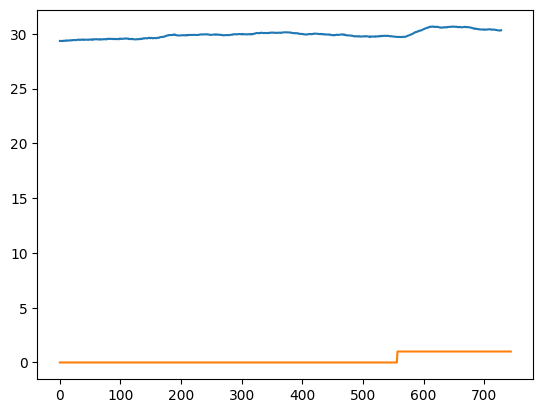

In [139]:
residual_test = np.sqrt(np.sum((preds-actual)**2, axis=(1,2)))

plt.plot(residual_test)
plt.plot(test_df_1.anomaly)

In [ ]:
adj_mat[1000, :, :]

In [ ]:
import seaborn as sns

sns.heatmap(adj_mat_train[1000, :, :])

In [ ]:
adj_mat_train[1000, :, :].mean(axis=(0,1))

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import imageio
import numpy as np

node_labels = ['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
               'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS']

# Example adjacency matrix data
adj_mats_all = adj_mat  # Replace this with your actual adjacency matrices

frames = []

# Loop through the first 30 adjacency matrices to create plots
for idx in range(30):
    selected_matrix = adj_mats_all[idx, :, :]
    
    # Create a graph
    G = nx.DiGraph()

    # Add nodes with labels
    for i, label in enumerate(node_labels):
        G.add_node(i, label=label)

    # Add edges based on the selected adjacency matrix
    threshold = 0.51  # You can set a different threshold here if needed
    for i in range(selected_matrix.shape[0]):
        for j in range(selected_matrix.shape[1]):
            if selected_matrix[i, j] > threshold:
                G.add_edge(i, j, weight=selected_matrix[i, j])

    # Get positions for the nodes in G
    pos = nx.spring_layout(G)

    # Create the plot
    plt.figure(figsize=(10, 10))

    # Draw the nodes
    nx.draw_networkx_nodes(G, pos)

    # Draw the edges
    edges = G.edges(data=True)
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='black')

    # Draw the labels
    labels = nx.get_node_attributes(G, 'label')
    nx.draw_networkx_labels(G, pos, labels, font_size=7)

    # Set the title
    plt.title(f'Adjacency Matrix Visualization {idx+1}')

    # Save the plot to a PNG file
    frame_path = f'frame_{idx}.png'
    plt.savefig(frame_path)
    plt.close()

    # Append the frame to the list
    frames.append(imageio.imread(frame_path))

# Create a GIF from the frames
gif_path = 'adjacency_matrix_visualizations.gif'
imageio.mimsave(gif_path, frames, duration=2)

# Clean up the frame files
import os
for idx in range(30):
    os.remove(f'frame_{idx}.png')

print(f'GIF saved at {gif_path}')

In [185]:
from sklearn.model_selection import KFold

def evaluate_model_predictions():
    dtype = torch.float32
    preds = []
    labels_tmp = []
    file_number = []
    residual_tmp_all = []
    adj_mats_all = []

    # Assuming data_pth and test_1 are defined globally
    files = os.listdir(data_pth + test_1)
    model.eval()
    print(files)
    
    for file in tqdm(files, desc="Processing files"):
        print(file)
        tmp_actual = []
        tmp_pred = []
        tmp = pd.read_csv(data_pth + test_1 + '/' + file, sep=';')

        t = tmp.anomaly.values
        test_df_1_tmp, _ = min_max_normalize(tmp.drop(columns=['datetime', 'anomaly', 'changepoint']), m_m_params)
        temporal_windows_tmp = create_sliding_windows(test_df_1_tmp, window_size=16, stride=1)
        tmp_dataset = TimeSeriesDataset(temporal_windows_tmp)
        tmp_loader = DataLoader(tmp_dataset, batch_size=64, shuffle=False)

        actual_values = []
        predicted_values = []
        adj_mats = []
        with torch.no_grad():
            for windows, _ in tmp_loader:
                windows = windows.squeeze(-1).type(dtype)

                # Get model predictions
                outputs, adj_matrix = model(windows)

                actual_values.extend(windows.numpy())
                predicted_values.extend(outputs.numpy())
                adj_mats.extend(adj_matrix.numpy())

        residual_tmp = np.sqrt(np.sum((np.array(predicted_values) - np.array(actual_values)) ** 2, axis=(1, 2)))
        kf = KFold(n_splits=25)
        thresholds = []

        for train_index, val_index in kf.split(residual_tmp):
            train_losses, val_losses = residual_tmp[train_index], residual_tmp[val_index]
            mean_loss = np.mean(train_losses)
            std_loss = np.std(train_losses)
            thresholds.append(mean_loss +  0.7*std_loss)

        final_threshold = np.mean(thresholds)
        print('Final Threshold: ', final_threshold)
        residual_tmp_all.append(residual_tmp)
        adj_mats_all.append(adj_mats)
        labels_tmp.append(t[-len(predicted_values):])
        i = int(file.split('.')[0])
        file_number.append([i] * len(predicted_values))
        preds.append(residual_tmp > final_threshold)
    
    preds = np.concatenate(preds, axis=0)
    labels = np.concatenate(labels_tmp, axis=0)
    file_number = np.concatenate(file_number, axis=0)
    
    return preds, labels, file_number, residual_tmp_all, adj_mats_all

# Call the function and retrieve the results
preds, labels, file_number, residual_tmp_all, adj_mats_all = evaluate_model_predictions()

['1.csv', '10.csv', '11.csv', '12.csv', '13.csv', '14.csv', '2.csv', '3.csv', '4.csv', '5.csv', '6.csv', '7.csv', '8.csv', '9.csv']


Processing files:   0%|          | 0/14 [00:00<?, ?it/s]

1.csv


Processing files:   7%|▋         | 1/14 [00:00<00:08,  1.45it/s]

Final Threshold:  30.166374573826793
10.csv


Processing files:  14%|█▍        | 2/14 [00:01<00:08,  1.35it/s]

Final Threshold:  6.1299604368209835
11.csv


Processing files:  21%|██▏       | 3/14 [00:02<00:08,  1.35it/s]

Final Threshold:  6.802175268888473
12.csv


Processing files:  29%|██▊       | 4/14 [00:02<00:07,  1.42it/s]

Final Threshold:  23.651288665771485
13.csv


Processing files:  36%|███▌      | 5/14 [00:03<00:05,  1.55it/s]

Final Threshold:  23.100887165069576
14.csv


Processing files:  43%|████▎     | 6/14 [00:03<00:04,  1.65it/s]

Final Threshold:  7.507461067199706
2.csv


Processing files:  50%|█████     | 7/14 [00:04<00:03,  1.78it/s]

Final Threshold:  30.44089151537418
3.csv


Processing files:  57%|█████▋    | 8/14 [00:05<00:03,  1.68it/s]

Final Threshold:  30.30157594132423
4.csv


Processing files:  64%|██████▍   | 9/14 [00:05<00:03,  1.43it/s]

Final Threshold:  30.677073882102967
5.csv


Processing files:  71%|███████▏  | 10/14 [00:06<00:02,  1.44it/s]

Final Threshold:  50.22520236206056
6.csv


Processing files:  79%|███████▊  | 11/14 [00:07<00:02,  1.45it/s]

Final Threshold:  41.381361984252926
7.csv


Processing files:  86%|████████▌ | 12/14 [00:08<00:01,  1.48it/s]

Final Threshold:  37.10988227081299
8.csv


Processing files:  93%|█████████▎| 13/14 [00:08<00:00,  1.47it/s]

Final Threshold:  4.858261011123658
9.csv


Processing files: 100%|██████████| 14/14 [00:09<00:00,  1.50it/s]

Final Threshold:  44.11961670684815


In [186]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, roc_auc_score

def fpr_score(true, pred):
    tn, fp, fn, tp = confusion_matrix(true, pred).ravel()
    return fp / (fp + tn)

# Metric names and corresponding functions
metric_functions = {
    'f1_score': f1_score,
    'fpr_score': fpr_score,
    'recall_score': recall_score,
    'auc_score': roc_auc_score,
}

def evaluate_metrics(labels, preds, file_number):
    for metric_name, metric_function in metric_functions.items():
        print(f"\n{metric_name}")
        for f in range(1, 15):
            true_labels = labels[file_number == f]
            pred_labels = preds[file_number == f]
            if len(true_labels) == 0 or len(pred_labels) == 0:
                continue
            print(metric_function(true_labels, pred_labels))

# Example usage
evaluate_metrics(labels, preds, file_number)


f1_score
0.8571428571428571
0.8605341246290801
0.9532237673830594
0.8517006802721088
0.9792935444579782
0.869198312236287
0.862295081967213
0.0779816513761468
0.9058663028649385
0.7735191637630662
0.6598837209302325
0.8470149253731344
0.1201716738197425
0.8581196581196582

fpr_score
0.0
0.0
0.022130013831258646
0.03461538461538462
0.012345679012345678
0.0
0.0
0.02197802197802198
0.0
0.16275862068965516
0.013831258644536652
0.0
0.26947040498442365
0.054514480408858604

recall_score
0.75
0.7552083333333334
0.9472361809045227
0.7924050632911392
0.9804878048780488
0.7686567164179104
0.7579250720461095
0.04218362282878412
0.827930174563591
0.757679180887372
0.5033259423503326
0.7346278317152104
0.10566037735849057
0.8311258278145696

auc_score
0.875
0.8776041666666667
0.9625530835366319
0.8788948393378774
0.9840710629328514
0.8843283582089552
0.8789625360230547
0.510102800425381
0.9139650872817955
0.7974602800988584
0.744747341852898
0.8673139158576052
0.41809498618703345
0.888305673702855

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np  # Import numpy for array operations
import seaborn as sns
node_labels = ['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
               'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS']

# List to store the graph figures
graph_figures = []

# Loop through the adjacency matrices in adj_mats_all
for idx, adj_matrix in enumerate(adj_mats_all):
    # Ensure adj_matrix is a NumPy array
    adj_matrix = np.array(adj_matrix)
    print(sns.heatmap(adj_matrix[600, :, :]))  # Debug print to check the shape
    
    # Select the 600th slice
    selected_matrix = adj_matrix[600]
    
    # Create a graph
    G = nx.DiGraph()

    # Add nodes with labels
    for i, label in enumerate(node_labels):
        G.add_node(i, label=label)

    # Add edges based on the selected adjacency matrix
    threshold = 0.6  # You can set a different threshold here if needed
    for i in range(selected_matrix.shape[0]):
        for j in range(selected_matrix.shape[1]):
            if selected_matrix[i, j] > threshold:
                G.add_edge(i, j, weight=selected_matrix[i, j])

    # Get positions for the nodes in G
    pos = nx.spring_layout(G)

    # Create the plot
    plt.figure(figsize=(10, 10))

    # Draw the nodes
    nx.draw_networkx_nodes(G, pos)

    # Draw the edges
    edges = G.edges(data=True)
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='black')

    # Draw the labels
    labels_graph = nx.get_node_attributes(G, 'label')
    nx.draw_networkx_labels(G, pos, labels_graph, font_size=7)

    # Set the title
    plt.title(f'Adjacency Matrix Visualization for Matrix {idx+1}')

    # Save the figure
    fig = plt.gcf()
    graph_figures.append(fig)

    # Optionally, show the plot
    plt.show()

# Now you have all the graph figures stored in the graph_figures list


In [117]:
tmp_anom_list = []
for file in files:
    tmp_df = pd.read_csv(data_pth+test_1+'/'+file, sep=';')
    tmp_anom_list.append(tmp_df.anomaly)
    plt.plot(tmp_df.anomaly)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\VSIE43\AppData\Local\miniconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\VSIE43\AppData\Local\Temp\ipykernel_29516\3465952271.py", line 3, in <module>
    tmp_df = pd.read_csv(data_pth+test_1+'/'+file, sep=';')
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\VSIE43\AppData\Local\miniconda3\Lib\site-packages\pandas\util\_decorators.py", line 311, in wrapper
    and p.name not in allow_args
       ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\VSIE43\AppData\Local\miniconda3\Lib\site-packages\pandas\io\parsers\readers.py", line 586, in read_csv
    """Generic reader of line files."""
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\VSIE43\AppData\Local\miniconda3\Lib\site-packages\pandas\io\parsers\readers.py", line 482, in _read
  File "c:\Users\VSIE43\AppData\Local\miniconda3\Lib\site-packages\pandas\

IndexError: list index out of range

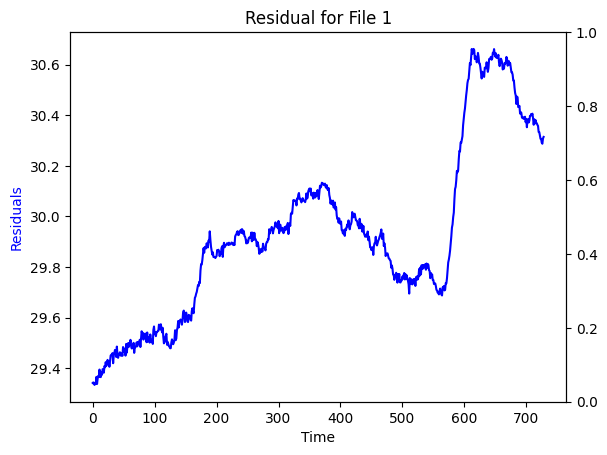

In [118]:
for i in range(len(residual_tmp_all)):
    fig, ax1 = plt.subplots()  # Create a new figure and axis for residuals

    ax1.plot(residual_tmp_all[i], 'b-')
    ax1.set_title(f'Residual for File {i+1}')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Residuals', color='b')

    ax2 = ax1.twinx()  # Create a second y-axis
    ax2.plot(tmp_anom_list[i], 'r-')
    ax2.set_ylabel('Anomaly', color='r')
    ax2.set_ylim(-0.1, 1.1)  # Set limits for the anomaly axis

    plt.show()

In [ ]:
from sklearn.model_selection import ParameterSampler

def hyperparameter_search(param_grid, data, num_samples=10):
    param_list = list(ParameterSampler(param_grid, n_iter=num_samples, random_state=42,))
    best_model = None
    best_score = float('-inf')
    best_params = None

    for params in tqdm(param_list, desc="Hyperparameter Search"):
        print(f"Testing parameters: {params}")
        model = GNNAnomalyDetection(input_dim, hidden_dim, output_dim, num_heads=params['num_heads'])

        criterion = nn.SmoothL1Loss(beta=0.5)
        optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])

        
        # temporal_windows_train = create_sliding_windows(data, window_size=16, stride=1)
        # train_dataset = TimeSeriesDataset(temporal_windows_train)
        # train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

        train_model(data, model, criterion, optimizer, num_epochs=params['num_epochs'], sparsity_weight=params['sparsity_weight'])

        adj_mat, preds, actual = evaluate_model(train_loader)
        score = -np.mean((preds - actual) ** 2)  # Mean squared error

        if score > best_score:
            best_score = score
            best_model = model
            best_params = params

    print("Best Hyperparameters:", best_params)
    return best_model

In [ ]:
param_grid = {
    'input_dim': [8, 16, 32],
    'hidden_dim': [16, 32, 64],
    'output_dim': [8, 16, 32],
    'num_heads': [8, 16],
    'learning_rate': [1e-3, 1e-4, 1e-5],
    'num_epochs': [50, 75, 50],
    'sparsity_weight': [1e-3, 1e-4, 1e-5],
    'dropout': [0.3, 0.5]
}

# Perform hyperparameter search
best_model = hyperparameter_search(param_grid, data = train_loader,num_samples=10)

In [ ]:
best_model